In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the provided dataset
data = pd.read_csv('regression_data.csv')

In [3]:
# Convert 'call_date' to datetime
data['call_date'] = pd.to_datetime(data['call_date'])

In [4]:
# Calculate business days per month (including Saturdays)
data['call_date_month'] = data['call_date'].dt.to_period('M')
unique_months = data['call_date_month'].unique()
business_days_per_month = []
for month in unique_months:
    start_date = month.to_timestamp()
    end_date = (month.to_timestamp() + pd.offsets.MonthEnd()).normalize()
    business_days = pd.bdate_range(start=start_date, end=end_date, freq='B').shape[0]
    business_days_per_month.append(business_days)

# Create a DataFrame with the results
business_days_df = pd.DataFrame({'call_date_month': unique_months, 'business_days': business_days_per_month})

# Merge the DataFrame with monthly values
data = data.merge(business_days_df, on='call_date_month', how='left')
# Drop the 'Unnamed: 0' column
data = data.drop(columns=['Unnamed: 0'])

In [5]:
# Generate additional features
# Calculate the Total Monthly Call Time
data['total_call_hours'] = data['offered_calls'] * data['avg_handle_time'] / 3600
data['staff_to_workload'] = data['phone'] / data['total_call_hours']
data['utilization'] = (data['phone'] - data['exceptions']) / data['paid']
data['shrinkage'] = (data['absence'] + data['exceptions']) / data['paid']

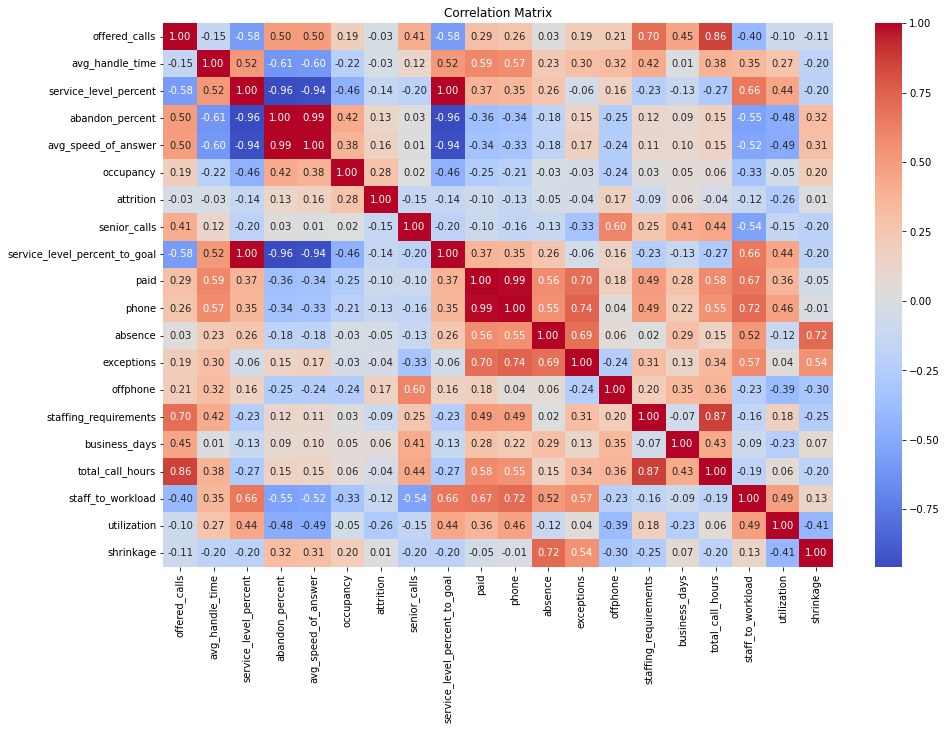

In [6]:
# Generate correlation matrix
corr = data.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

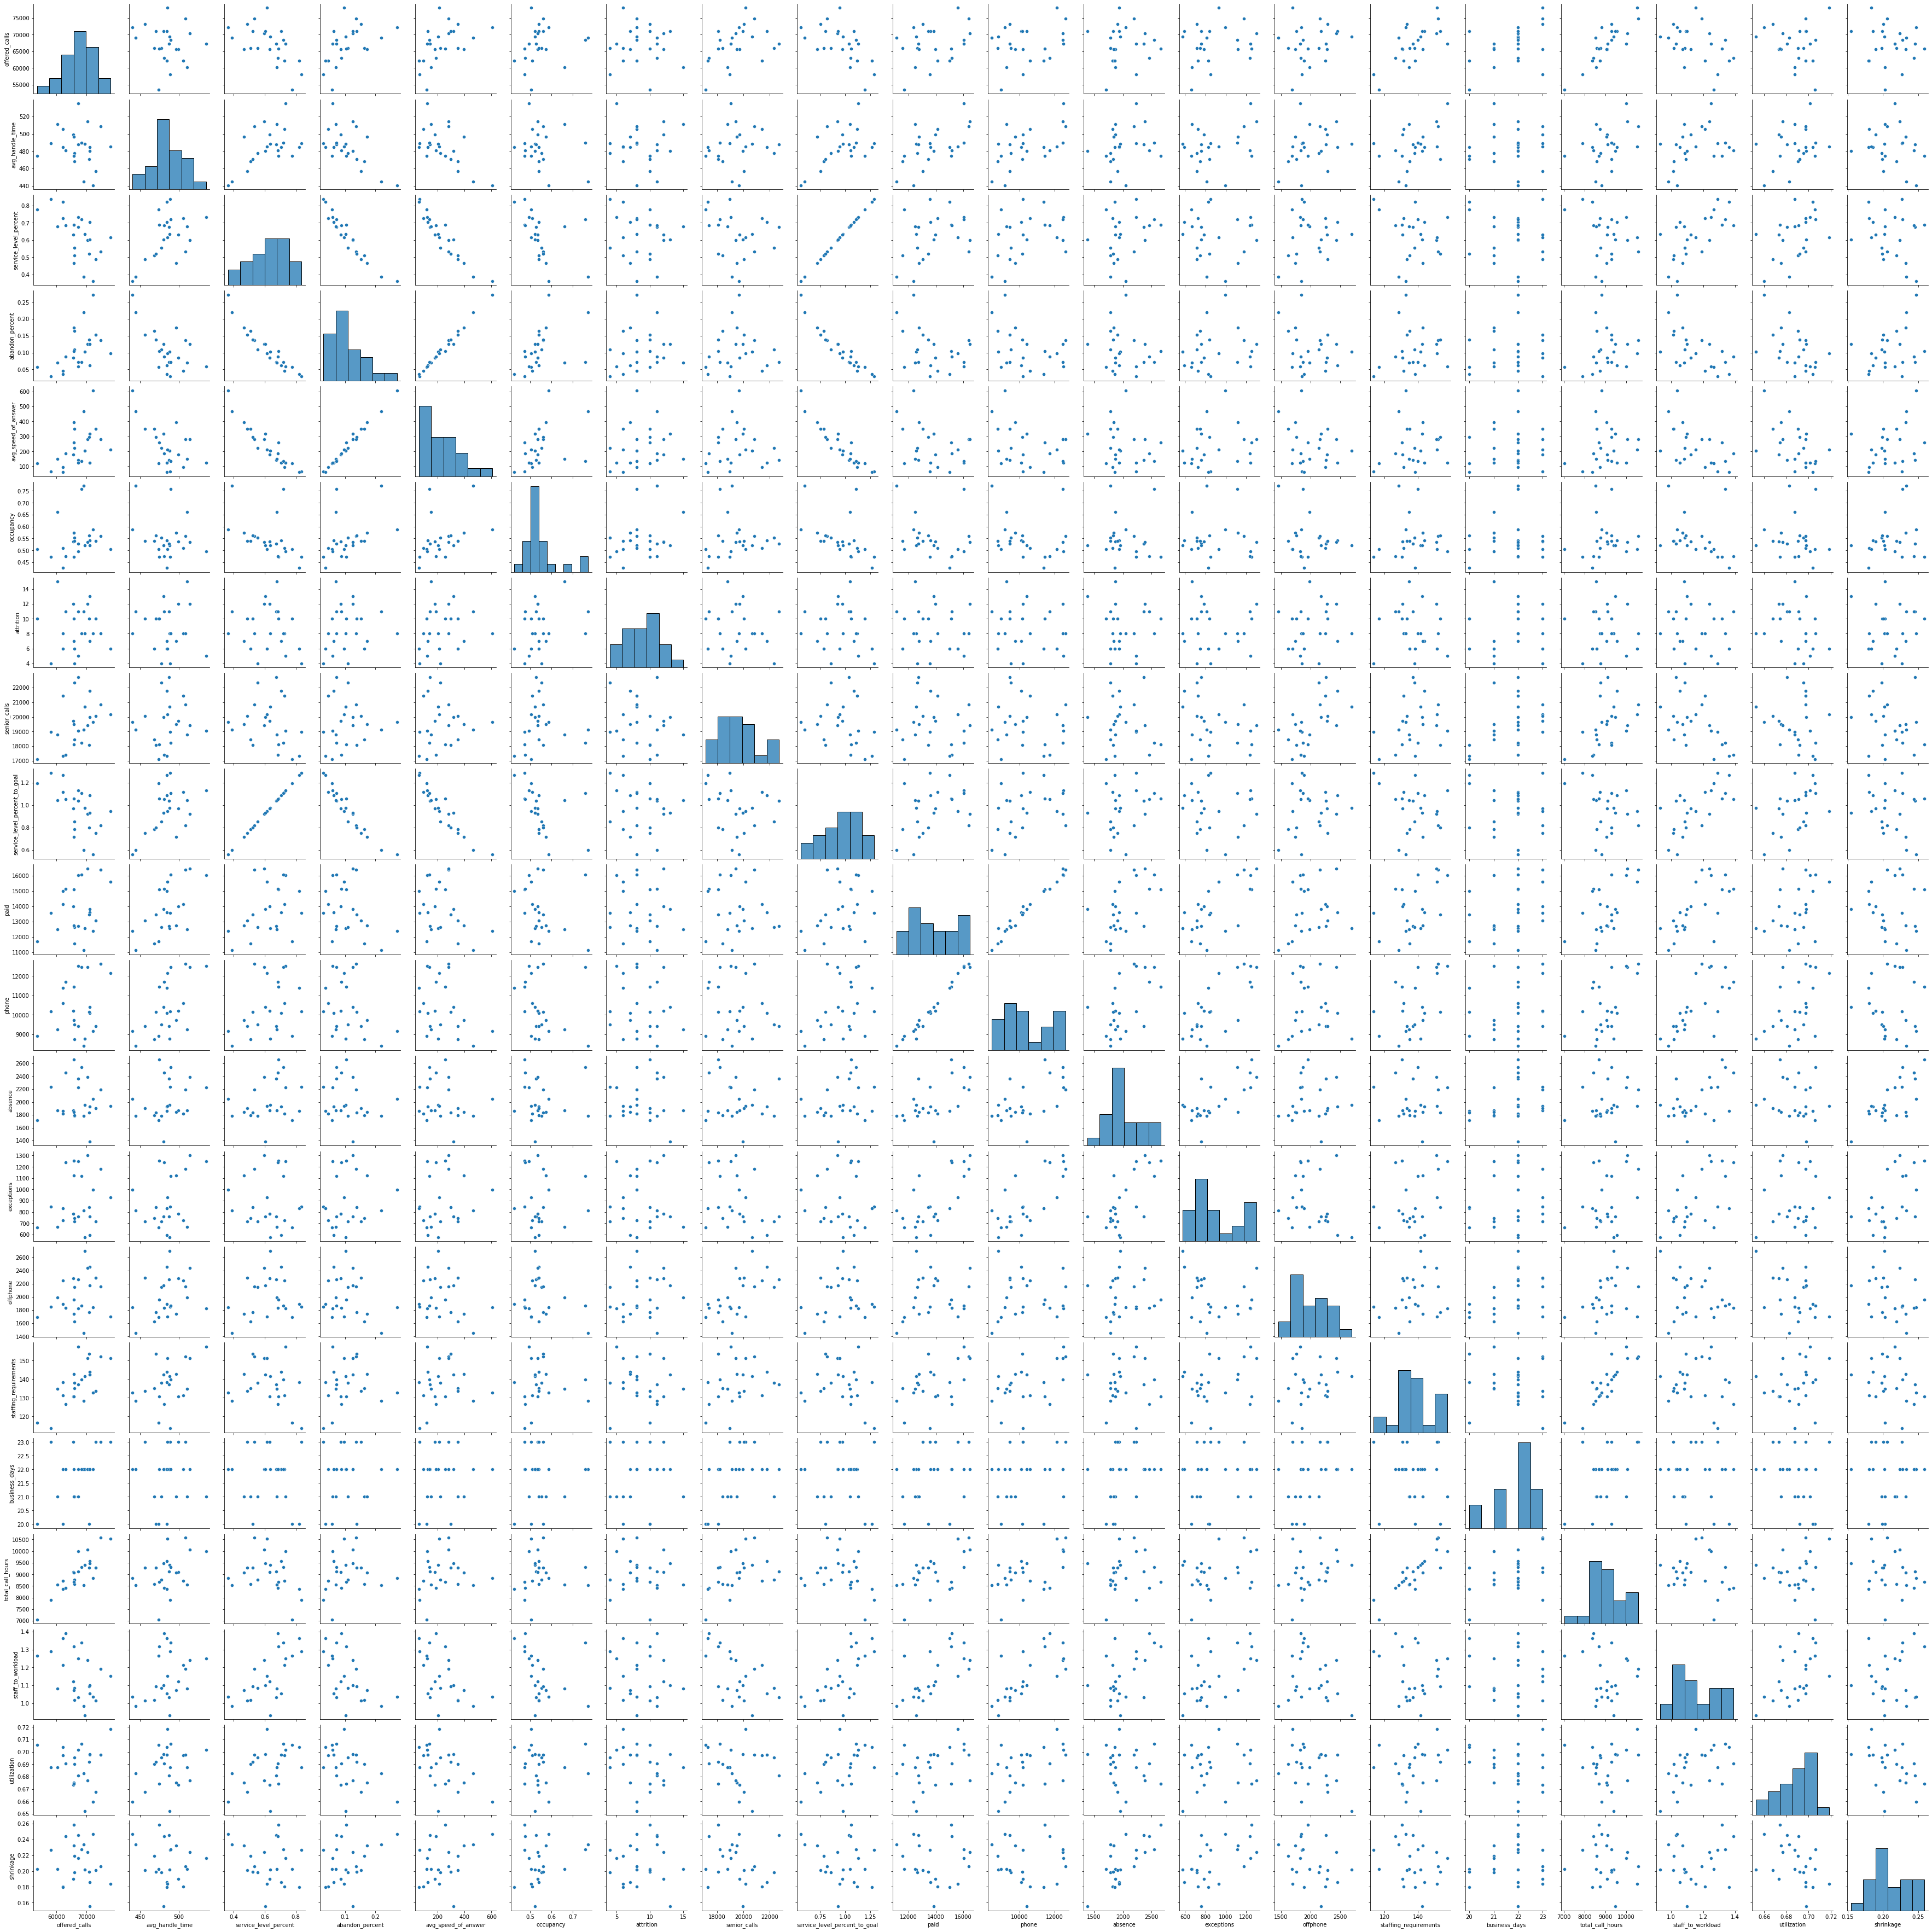

In [7]:
# Generate pairplot for selected features
selected_features = ['avg_handle_time', 'occupancy', 'service_level_percent_to_goal', 'senior_calls', 'staffing_requirements']
sns.pairplot(data)
plt.show()

In [8]:
# Calculate the Staffing Requirements
shrinkage = data['shrinkage']
occupancy = data['occupancy'].mean()
working_hours_per_day = 7.1667
data['staffing_requirements'] = ((((data['total_call_hours']) ) / occupancy) * (1 + shrinkage)) / (data['business_days'] * working_hours_per_day)

In [9]:
# Define the feature set and the target variable
X = data.drop(['staffing_requirements', 'call_date', 'call_date_month', 'business_days'], axis=1)
y = data['staffing_requirements']

In [10]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Create a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [12]:
# Predict staffing requirements
y_pred = model.predict(X_test)

In [13]:
# Calculate and print the root mean square error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Square Error: {rmse}')

Root Mean Square Error: 5.907258650601697


In [14]:
# Generate correlation matrix
corr = data.corr()

# Display the correlation values related to 'staffing_requirements'
staffing_corr = corr['staffing_requirements']
print(staffing_corr)

offered_calls                    0.698117
avg_handle_time                  0.416743
service_level_percent           -0.231768
abandon_percent                  0.118965
avg_speed_of_answer              0.107294
occupancy                        0.032598
attrition                       -0.087289
senior_calls                     0.254275
service_level_percent_to_goal   -0.231768
paid                             0.493224
phone                            0.485202
absence                          0.018459
exceptions                       0.306687
offphone                         0.204276
staffing_requirements            1.000000
business_days                   -0.074722
total_call_hours                 0.869446
staff_to_workload               -0.158387
utilization                      0.178425
shrinkage                       -0.250427
Name: staffing_requirements, dtype: float64


In [19]:
# Print the columns in the scenario DataFrame
print("Columns in scenario DataFrame:")
print(scenario.columns)

# Print the features used to train the model
print("\nFeatures used to train the model:")
print(X_train.columns)


Columns in scenario DataFrame:
Index(['offered_calls', 'avg_handle_time', 'service_level_percent',
       'abandon_percent', 'avg_speed_of_answer', 'occupancy', 'attrition',
       'senior_calls', 'service_level_percent_to_goal', 'paid', 'phone',
       'absence', 'exceptions', 'offphone', 'total_call_hours',
       'staff_to_workload', 'utilization', 'shrinkage', 'total_call_minutes'],
      dtype='object')

Features used to train the model:
Index(['offered_calls', 'avg_handle_time', 'service_level_percent',
       'abandon_percent', 'avg_speed_of_answer', 'occupancy', 'attrition',
       'senior_calls', 'service_level_percent_to_goal', 'paid', 'phone',
       'absence', 'exceptions', 'offphone', 'total_call_hours',
       'staff_to_workload', 'utilization', 'shrinkage'],
      dtype='object')


In [20]:
# Define the range of changes for each variable
sl_goal_changes = range(65, 30, -5)
asa_changes = range(30, 1500, 500)  # Hypothetical changes to total call hours
workload_changes = range(0, 1500, 500)  # Hypothetical changes to total call hours
occupancy_changes = range(0, 41, 5)  # Hypothetical changes to occupancy
shrinkage_changes = range(0, 40, 10)  # Hypothetical changes to shrinkage

# Create a list to hold all scenarios
simulations = []

# Generate scenarios
for sl_goal in sl_goal_changes:
    for workload_change in workload_changes:
        for occupancy_change in occupancy_changes:
            for shrinkage_change in shrinkage_changes:
                # Create a copy of the test set
                scenario = X_test.copy()
                # Adjust the variables
                scenario['service_level_percent_to_goal'] = sl_goal / 100
                scenario['total_call_hours'] += workload_change
                scenario['occupancy'] += occupancy_change / 100
                scenario['shrinkage'] += shrinkage_change / 100
                
                # Calculate dependent variables based on the adjusted variables
                scenario['staff_to_workload'] = scenario['phone'] / scenario['total_call_hours']
                scenario['utilization'] = (scenario['phone'] - scenario['exceptions']) / scenario['paid']
                
                # Now make predictions
                scenario['predicted_staff_requirements'] = model.predict(scenario)
                
                # Add the scenario to the simulations list
                simulations.append(scenario)

# Combine all scenarios into one DataFrame
simulations_df = pd.concat(simulations, ignore_index=True)


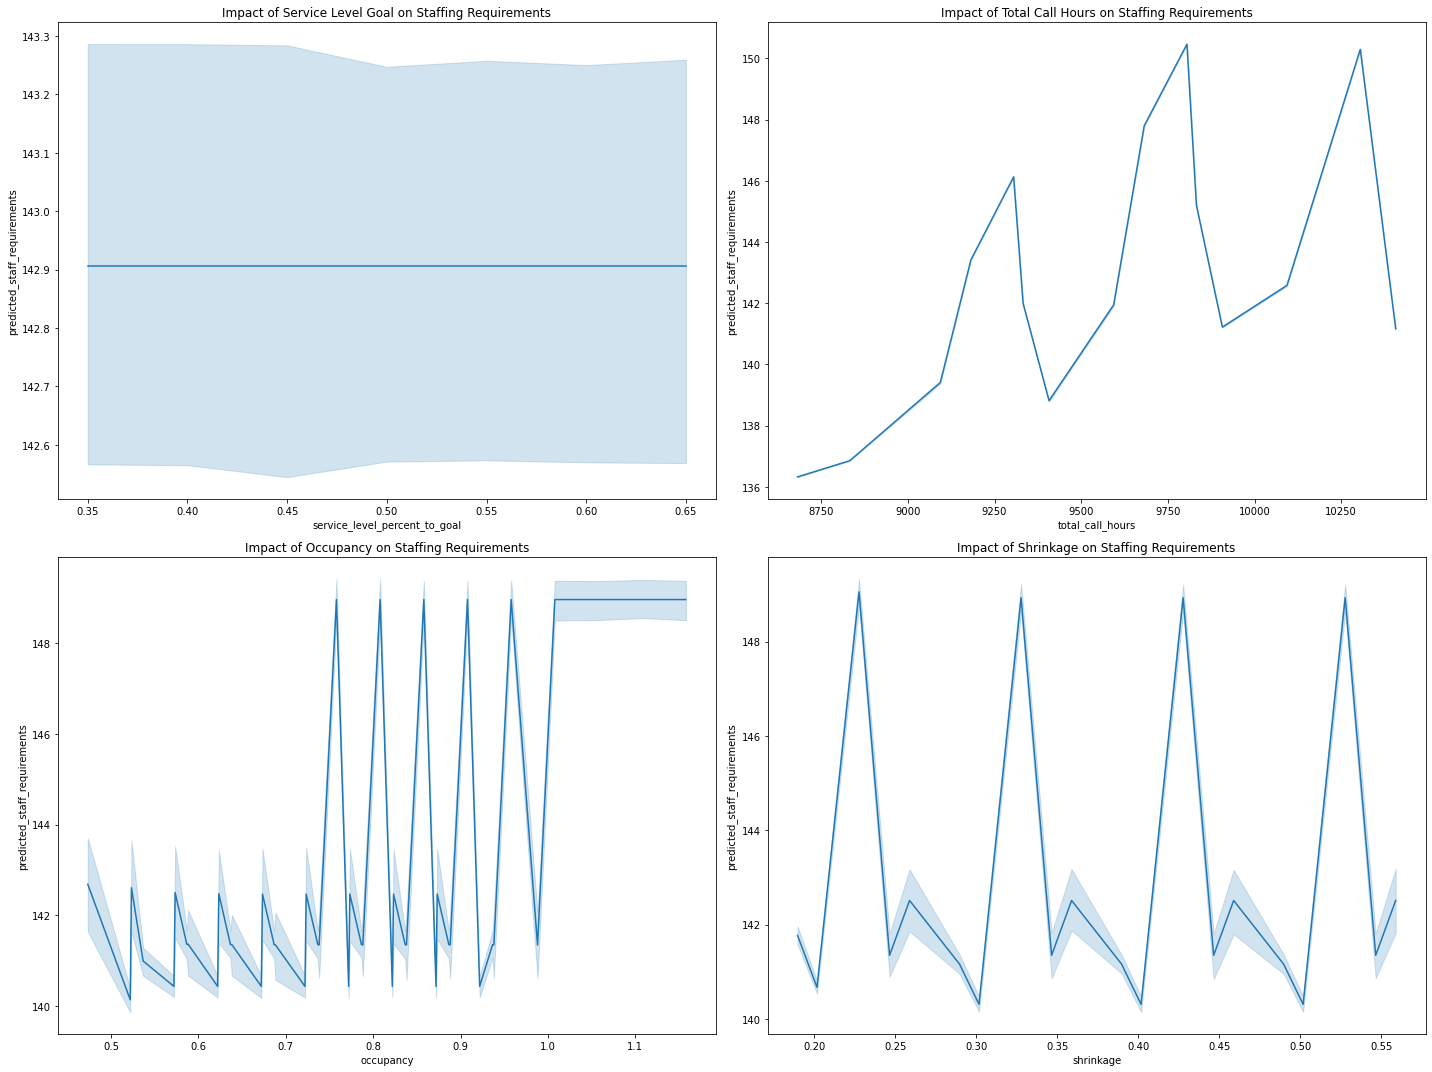

In [22]:
# Visualize the impact of changes to the service level goal, total call hours, occupancy, and shrinkage on staffing requirements
plt.figure(figsize=(20, 15))

plt.subplot(2, 2, 1)
sns.lineplot(data=simulations_df, x='service_level_percent_to_goal', y='predicted_staff_requirements')
plt.title('Impact of Service Level Goal on Staffing Requirements')

plt.subplot(2, 2, 2)
sns.lineplot(data=simulations_df, x='total_call_hours', y='predicted_staff_requirements')
plt.title('Impact of Total Call Hours on Staffing Requirements')

plt.subplot(2, 2, 3)
sns.lineplot(data=simulations_df, x='occupancy', y='predicted_staff_requirements')
plt.title('Impact of Occupancy on Staffing Requirements')

plt.subplot(2, 2, 4)
sns.lineplot(data=simulations_df, x='shrinkage', y='predicted_staff_requirements')
plt.title('Impact of Shrinkage on Staffing Requirements')

plt.tight_layout()
plt.show()
